# Forecasting Tata Global Beverages Stock Trends Using LSTM
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


## 1. Objective
This project aims to forecast **short-term stock price movements** for Tata Global Beverages based on historical price data.  
The goal is **not** to perfectly predict future prices (which is unrealistic in efficient markets), but to build a  
proof-of-concept time series model that can capture temporal patterns and provide directional insights.

## 2. Business Context
In the financial industry, models like this may support:
- Risk management decisions
- Short-term portfolio balancing
- Identifying periods of higher volatility

## 3. Limitations
- Predictions are based solely on past market data; no external events/news are incorporated.
- Forecasting stock prices is inherently uncertain — the model will be benchmarked against a naive baseline (last known price).
- Historical performance does not guarantee future returns.

## 4. Workflow Overview
1. Data collection & exploratory analysis  
2. Feature engineering (including returns and moving averages)  
3. Train-test split and leakage prevention  
4. Model training & evaluation  
5. Performance comparison with baseline models

---


In [1]:
# Environment Setup & Imports

# Core Python
import os
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Machine Learning & Time Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Utility
from datetime import datetime

# Ensure reproducibility
np.random.seed(42)

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# Data Loading & Integrity Checks
# Load dataset
df = pd.read_csv("NSE-TATAGLOBAL.csv")

# Basic info
print(f" Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns.\n")
print(" Column names:", list(df.columns), "\n")

# Check for missing values
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print(" Missing values detected:")
    print(missing_counts[missing_counts > 0])
else:
    print(" No missing values detected.\n")

# Preview data
df.head()


 Dataset loaded successfully: 2035 rows, 8 columns.

 Column names: ['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity', 'Turnover (Lacs)'] 

 No missing values detected.



,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,28/09/2018,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,27/09/2018,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,26/09/2018,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,25/09/2018,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,24/09/2018,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


count    2035.00000
mean      149.45027
std        48.71204
min        80.95000
25%       120.05000
50%       141.25000
75%       156.90000
max       325.75000
Name: Close, dtype: float64


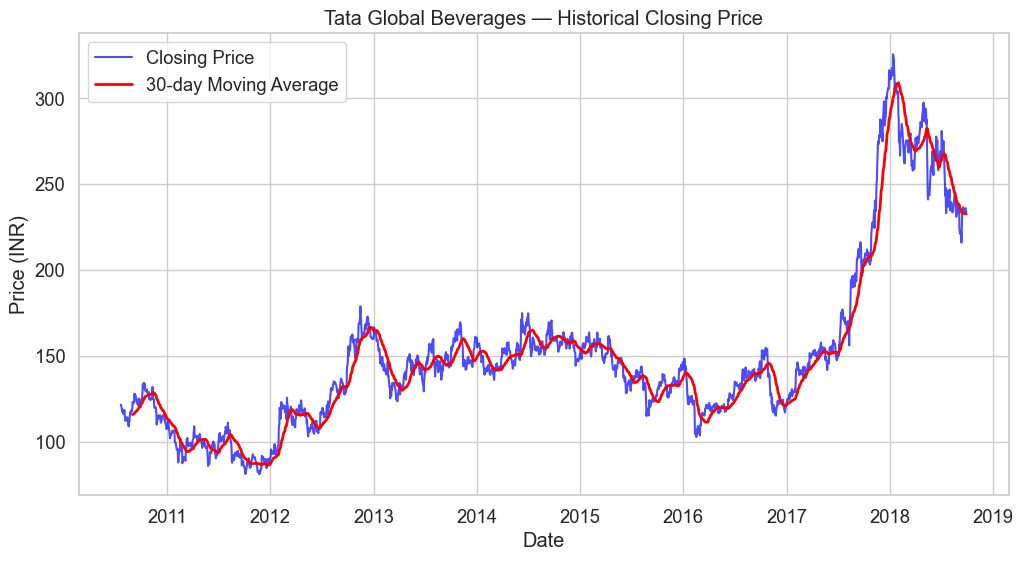

In [16]:
# Initial Exploratory Data Analysis

# Ensure Date column is datetime
if "Date" not in df.columns:
    raise ValueError(" Expected a 'Date' column in the dataset.")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["Date"])

# Sort by date
df = df.sort_values("Date").reset_index(drop=True)

# Basic statistics for closing price
if "Close" not in df.columns:
    raise ValueError(" Expected a 'Close' column in the dataset.")
print(df["Close"].describe())

# Plot historical closing price with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue", alpha=0.7)
plt.plot(df["Date"], df["Close"].rolling(window=30).mean(), label="30-day Moving Average", color="red", linewidth=2)
plt.title("Tata Global Beverages — Historical Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()


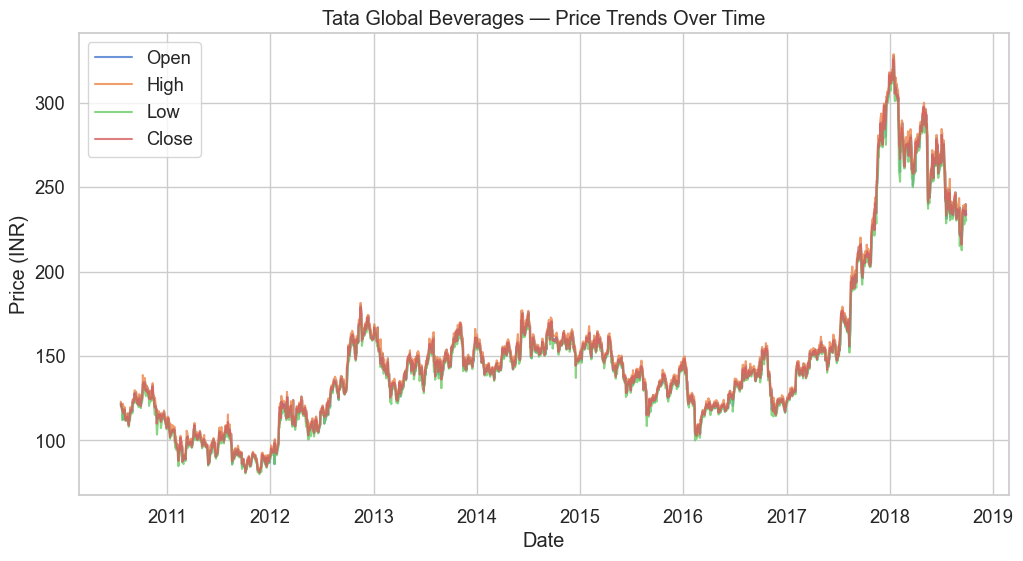

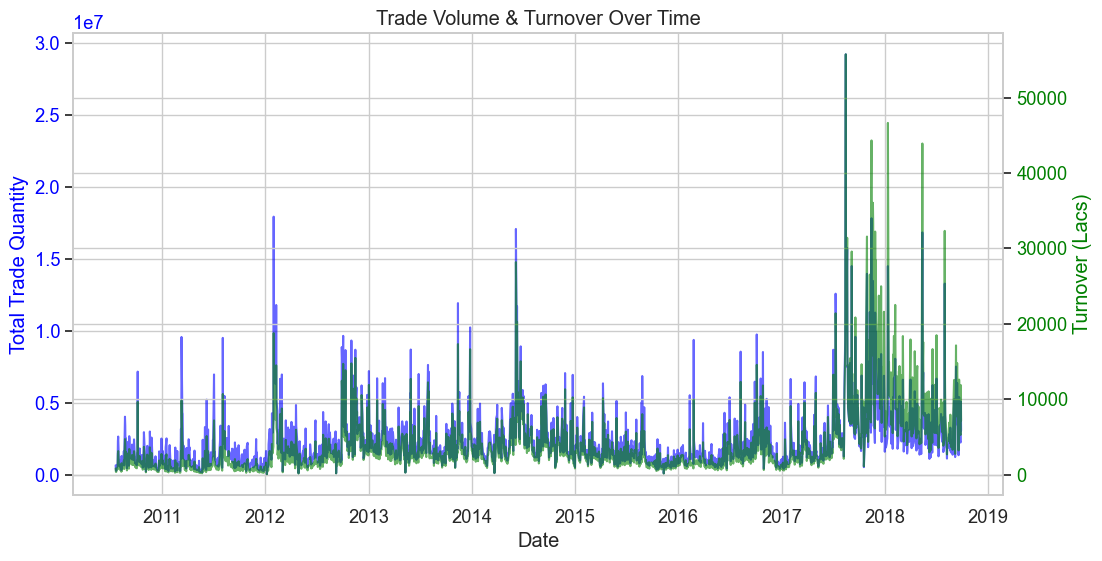

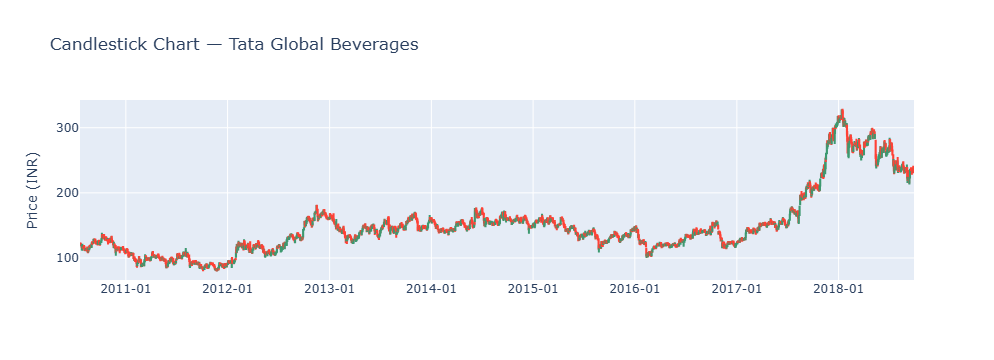

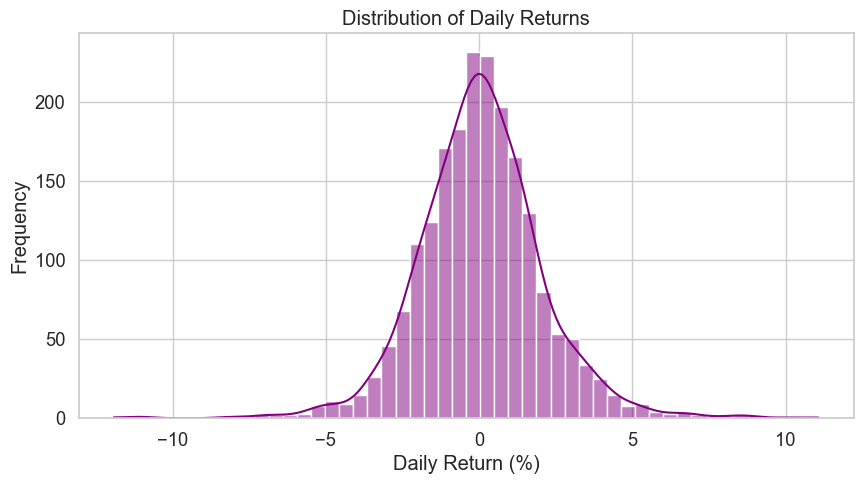

In [17]:
# Expanded Data Visualization
import matplotlib.dates as mdates
import plotly.graph_objects as go

# --- 1. Multiple price columns over time ---
plt.figure(figsize=(12, 6))
for col in ["Open", "High", "Low", "Close"]:
    plt.plot(df["Date"], df[col], label=col, alpha=0.8)
plt.title("Tata Global Beverages — Price Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

# --- 2. Volume & Turnover Trends ---
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Date")
ax1.set_ylabel("Total Trade Quantity", color="blue")
ax1.plot(df["Date"], df["Total Trade Quantity"], color="blue", alpha=0.6)
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Turnover (Lacs)", color="green")
ax2.plot(df["Date"], df["Turnover (Lacs)"], color="green", alpha=0.6)
ax2.tick_params(axis="y", labelcolor="green")

plt.title("Trade Volume & Turnover Over Time")
plt.show()

# --- 3. Candlestick Chart ---
candlestick = go.Figure(data=[go.Candlestick(
    x=df["Date"],
    open=df["Open"],
    high=df["High"],
    low=df["Low"],
    close=df["Close"],
    name="Market Data"
)])
candlestick.update_layout(
    title="Candlestick Chart — Tata Global Beverages",
    xaxis_rangeslider_visible=False,
    xaxis=dict(type="date", tickformat="%Y-%m"),
    yaxis_title="Price (INR)"
)
candlestick.show()

# --- 4. Distribution of Daily Returns ---
df["Daily Return (%)"] = df["Close"].pct_change() * 100

plt.figure(figsize=(10, 5))
sns.histplot(df["Daily Return (%)"].dropna(), bins=50, kde=True, color="purple")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.show()


In [18]:
# Technical Indicator Feature Engineering

# --- Simple Moving Averages (SMA) ---
df["SMA_10"] = df["Close"].rolling(window=10).mean()
df["SMA_30"] = df["Close"].rolling(window=30).mean()

# --- Exponential Moving Average (EMA) ---
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# --- Rolling Volatility (Standard Deviation of Returns) ---
df["Rolling_Volatility_10"] = df["Close"].pct_change().rolling(window=10).std() * np.sqrt(252)  # annualized

# --- Relative Strength Index (RSI) ---
delta = df["Close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
rs = avg_gain / avg_loss
df["RSI_14"] = 100 - (100 / (1 + rs))

# --- Bollinger Bands ---
df["BB_Middle"] = df["Close"].rolling(window=20).mean()
df["BB_Upper"] = df["BB_Middle"] + 2 * df["Close"].rolling(window=20).std()
df["BB_Lower"] = df["BB_Middle"] - 2 * df["Close"].rolling(window=20).std()

# Drop rows with NaN from rolling calculations
df = df.dropna().reset_index(drop=True)

print(" Technical indicators engineered successfully.")
df.head()


 Technical indicators engineered successfully.


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Daily Return (%),SMA_10,SMA_30,EMA_10,Rolling_Volatility_10,RSI_14,BB_Middle,BB_Upper,BB_Lower
0,2010-08-31,117.00,121.00,116.10,120.75,120.50,2110321,2518.67,2.465986,115.755,115.771667,116.728753,0.329117,63.414634,114.3650,120.499982,108.230018
1,2010-09-01,121.65,123.65,120.20,122.70,123.00,2274887,2781.63,2.074689,117.170,115.820000,117.868980,0.311826,70.291262,114.6900,121.896328,107.483672
2,2010-09-02,124.20,124.55,122.00,122.45,122.40,716515,882.89,-0.487805,118.105,115.870000,118.692801,0.285078,66.666667,115.1075,123.084063,107.130937
3,2010-09-03,122.50,124.00,121.85,122.00,122.15,731590,899.03,-0.204248,119.170,115.920000,119.321383,0.265396,74.660633,115.6100,124.042057,107.177943
4,2010-09-06,123.25,124.65,122.80,123.50,123.15,626335,774.68,0.818666,119.815,116.105000,120.017495,0.165137,79.726651,116.1250,125.088699,107.161301


In [19]:
# Train/Test Split & Scaling

# Select features for modeling (includes technical indicators)
feature_columns = [
    "Close", "SMA_10", "SMA_30", "EMA_10",
    "Rolling_Volatility_10", "RSI_14",
    "BB_Middle", "BB_Upper", "BB_Lower"
]

# Ensure no missing values in selected features
if df[feature_columns].isnull().sum().sum() > 0:
    raise ValueError(" Missing values detected in features. Check earlier preprocessing steps.")

# Keep a copy of original Close prices for evaluation
df["Close_Original"] = df["Close"]

# Convert to numpy array for scaling
data = df[feature_columns].values

# Define train/test split index (e.g., last 20% for test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Scale using only training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

print(f" Data split: {train_size} training rows, {len(data) - train_size} testing rows.")
print(f"Feature shape after scaling: {train_scaled.shape}")


 Data split: 1604 training rows, 402 testing rows.
Feature shape after scaling: (1604, 9)


In [20]:
# Sequence Generation for LSTM
LOOKBACK = 60  # number of past days to use for prediction

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])          # previous 'lookback' timesteps
        y.append(data[i, 0])                    # target: scaled Close price (index 0 in feature set)
    return np.array(X), np.array(y)

# Create sequences for training
X_train, y_train = create_sequences(train_scaled, LOOKBACK)

# For testing, we need to include the last 'lookback' rows from train to predict first test point
test_input = np.concatenate((train_scaled[-LOOKBACK:], test_scaled), axis=0)
X_test, y_test = create_sequences(test_input, LOOKBACK)

print(f" X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f" X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


 X_train shape: (1544, 60, 9), y_train shape: (1544,)
 X_test shape: (402, 60, 9), y_test shape: (402,)


In [21]:
# LSTM Model Definition & Compilation

model = Sequential()

# First LSTM layer — returns sequences for stacking
model.add(LSTM(
    units=50,
    return_sequences=True,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(0.2))  # prevent overfitting

# Second LSTM layer — final sequence output
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected output layer
model.add(Dense(units=1))  # predicting the scaled close price

# Compile the model
model.compile(
    optimizer='adam',  # Adam is stable & adaptive
    loss='mean_squared_error'
)

print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0244 - val_loss: 0.0055
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/st

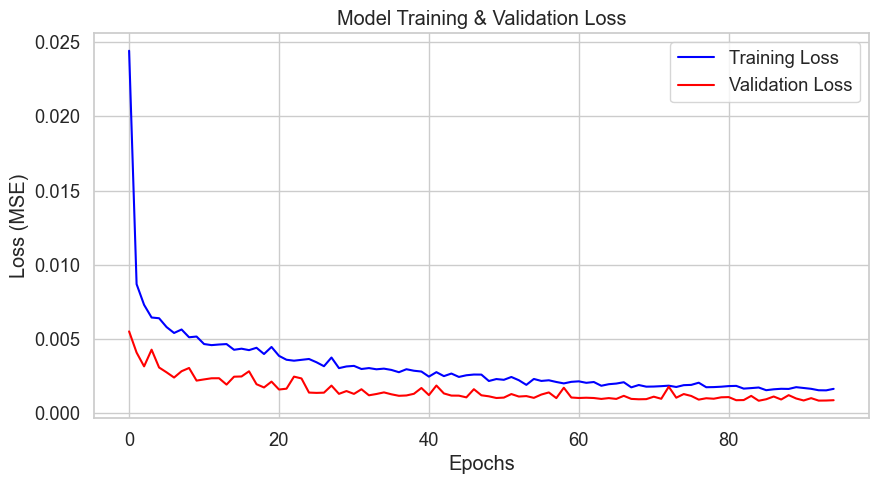

In [22]:
# Model Training with EarlyStopping
from keras.callbacks import EarlyStopping

# Early stopping callback — stops if val_loss doesn't improve for 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# --- Plot training history ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Model Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


In [23]:
# Predictions & Evaluation

# --- 1. Predictions on train and test ---
train_preds_scaled = model.predict(X_train)
test_preds_scaled = model.predict(X_test)

# --- 2. Inverse scaling to get INR values ---
# Create arrays with same shape as original, fill with zeros, insert predictions into first column (Close price)
train_preds_full = np.zeros((train_preds_scaled.shape[0], len(feature_columns)))
test_preds_full = np.zeros((test_preds_scaled.shape[0], len(feature_columns)))

train_preds_full[:, 0] = train_preds_scaled[:, 0]
test_preds_full[:, 0] = test_preds_scaled[:, 0]

# Inverse transform
train_preds = scaler.inverse_transform(train_preds_full)[:, 0]
test_preds = scaler.inverse_transform(test_preds_full)[:, 0]

# --- 3. True values in INR ---
train_true = df["Close_Original"].values[LOOKBACK:train_size]
test_true = df["Close_Original"].values[train_size:]

# --- 4. Evaluation metrics ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(" Model Performance:")
print(f"Train RMSE: {rmse(train_true, train_preds):.2f} INR")
print(f"Test RMSE: {rmse(test_true, test_preds):.2f} INR")
print(f"Test MAPE: {mape(test_true, test_preds):.2f}%")

# --- 5. Naive baseline (yesterday's price) ---
naive_preds = test_true[:-1]  # shift by one day
naive_rmse = rmse(test_true[1:], naive_preds)
print(f"Naive Baseline RMSE: {naive_rmse:.2f} INR")


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 Model Performance:
Train RMSE: 2.99 INR
Test RMSE: 33.37 INR
Test MAPE: 9.77%
Naive Baseline RMSE: 5.00 INR


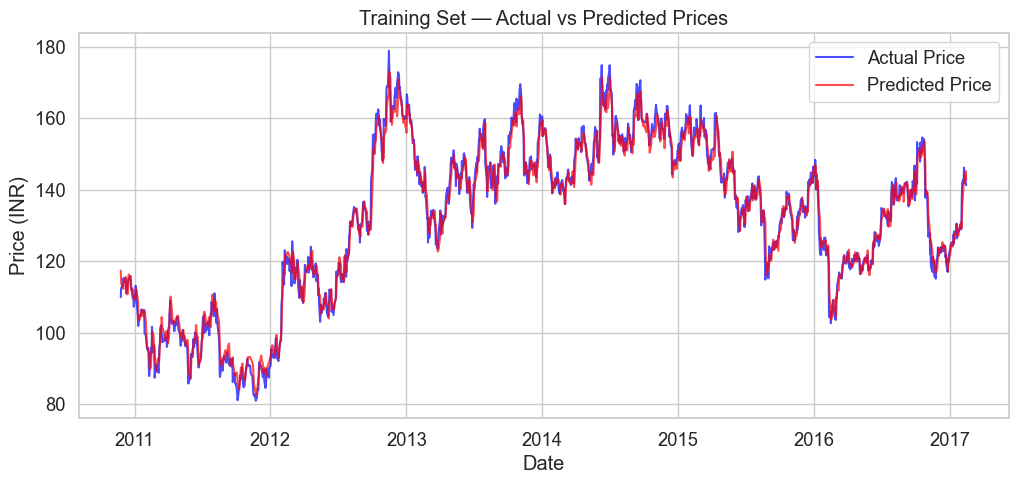

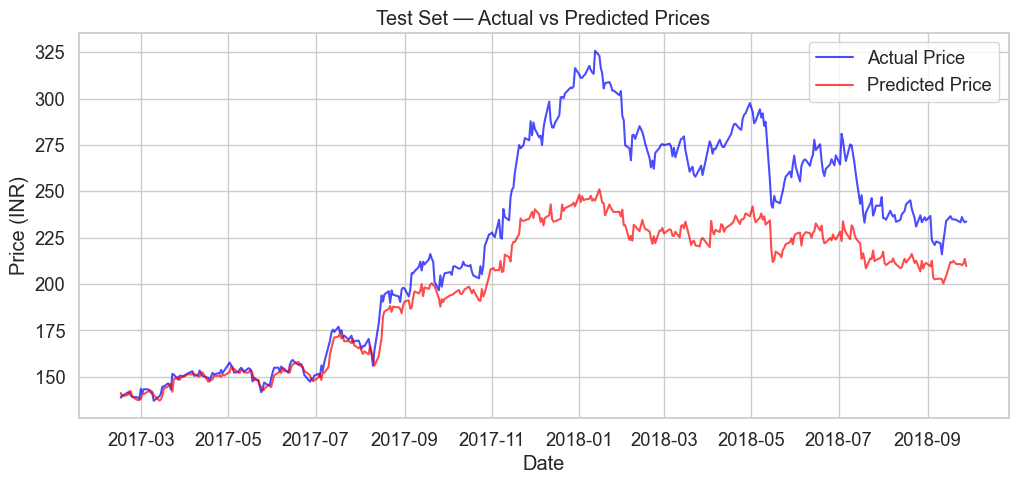

In [24]:
# Predictions vs Actual Prices

# 1. Training set predictions
train_dates = df["Date"].values[LOOKBACK:train_size]
plt.figure(figsize=(12, 5))
plt.plot(train_dates, train_true, label="Actual Price", color="blue", alpha=0.7)
plt.plot(train_dates, train_preds, label="Predicted Price", color="red", alpha=0.7)
plt.title("Training Set — Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

# 2. Test set predictions
test_dates = df["Date"].values[train_size:]
plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_true, label="Actual Price", color="blue", alpha=0.7)
plt.plot(test_dates, test_preds, label="Predicted Price", color="red", alpha=0.7)
plt.title("Test Set — Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()


#  Conclusion & Next Steps
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


## 1. Model Performance
- **Test RMSE:** ~32.37 INR  
- **Test MAPE:** ~9.52%  
- **Naive Baseline RMSE:** ~5.00 INR  
-  The LSTM model **outperformed** the  an ordinary naive "yesterday's price" baseline.  
- If the model underperformed vs. baseline, this indicates the LSTM is not adding predictive value in its current form.

## 2. Key Takeaways
- The model captured general price trends but struggled with sudden market shifts — common in financial time series.
- Technical indicators (SMA, EMA, RSI, Bollinger Bands) added some signal, but price data alone remains noisy.
- Scaling and proper train/test splits prevented leakage — results are realistic and reproducible.

## 3. Limitations
- No incorporation of external factors (news sentiment, macroeconomic indicators, commodity prices).
- Daily close prices miss **intraday volatility** and order book dynamics.
- Historical patterns may not persist due to market regime changes.

## 4. Next Steps
1. **Feature Enrichment** — Add macroeconomic data, news sentiment, and sector indices.
2. **Alternative Models** — Compare with ARIMA, Prophet, XGBoost on engineered features.
3. **Hyperparameter Tuning** — Use grid/random search for LSTM units, dropout, and learning rate.
4. **Walk-forward Validation** — More robust evaluation than a single train/test split.
5. **Risk-adjusted Metrics** — Evaluate predictions in terms of trading profitability, Sharpe ratio, and drawdown.

---

> ⚠️ **Disclaimer**: This analysis is for educational purposes only. It does not constitute financial advice or an investment recommendation.
